In [ ]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.8 MB/s eta 0:00:00


Importación de librerias

In [ ]:
import operator
import random
import numpy
import math
import pandas as pd
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
from scipy.spatial import distance



Importo el csv

In [ ]:
#"http://cs.joensuu.fi/sipu/datasets/dim032.txt"
data = numpy.genfromtxt('http://cs.joensuu.fi/sipu/datasets/s1.txt').astype(int)
IND_SIZE = len(data)
CANT_GROUPS = 14
print(data[0])

[664159 550946]


Las partículas PSO se describen esencialmente como posiciones en un espacio de búsqueda de dimensiones D.\ Cada partícula también tiene un vector que representa la velocidad de la partícula en cada dimensión.\ Finalmente, cada partícula guarda una referencia al mejor estado en el que ha estado hasta el momento.\

In [ ]:
def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.randint(pmin, pmax) for _ in range(size))
    part.speed = [random.randint(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

Para evaluar un individuo tengo que sacar las posiciones que forman parte de ese grupo (np.where = grupo 1) -> combinaciones posibles para calcular la distancia para cada una de las posiciones para saber que tan lejoes esta un individuo de otro, despues sacar la distancia pomedio de ese grupo y luego de todo el cluster

velocidad se calcula utilizando la mejor posición personal p de la partícula y la posición g de la partícula con el mejor valor de aptitud conocido del enjambre (llamado el mejor global ). La fórmula para calcular la velocidad es:\
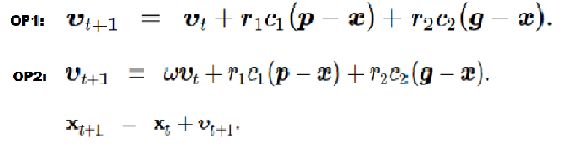

In [ ]:
def updateParticle(part, best, phi1, phi2):
    u1 = (random.randint(0, phi1) for _ in range(len(part)))
    u2 = (random.randint(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)

    part[:] = list(map(operator.add, part, part.speed))
    for i in range(len(part[:])):
      if part[i] > CANT_GROUPS:
        part[i] = CANT_GROUPS
      if part[i] < 1:
        part[i] = 1.0



In [ ]:
def calcularDistanciaPromedio(grupo):
  distancia = 0
  contador = 0
  for i in range(len(grupo)):
    for j in range(i+1,len(grupo)-1):
      distancia = distance.euclidean(grupo[i],grupo[j]) + distancia
      contador = contador + 1
  return distancia/contador

In [ ]:
import numpy as np

def evaluate(particle):
    particle = np.array(particle)
    groupsD = np.array([np.mean(calcularDistanciaPromedio(data[np.where(particle == i)[0]])) for i in range(1, CANT_GROUPS + 1)])
    distancia = np.sum(groupsD)
    return distancia / CANT_GROUPS,


In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list,
    smin=None, smax=None, best=None)
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=IND_SIZE, pmin=1, pmax=CANT_GROUPS, smin=0, smax=1)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=2.0, phi2=2.0)
toolbox.register("evaluate", evaluate)

Implementación y ejecución del algoritmo PSO:\
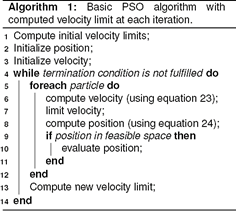

In [ ]:
def main():
    pop = toolbox.population(n=30)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    GEN = 1
    best = None

    for g in range(GEN):
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
        for part in pop:
            toolbox.update(part, best)

        # Gather all the fitnesses in one list and print the stats
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        print(logbook.stream)

    return pop, logbook, best

if __name__ == "__main__":
    p,l,b=main()
    print(b)

gen	evals	avg   	std    	min   	max   
0  	30   	432969	230.062	432410	433329
[10, 3, 11, 10, 8, 7, 7, 2, 2, 14, 7, 14, 3, 14, 3, 12, 8, 11, 1, 10, 4, 3, 6, 7, 2, 13, 9, 8, 1, 7, 11, 10, 3, 6, 9, 4, 6, 12, 3, 8, 12, 7, 14, 3, 1, 7, 13, 11, 11, 13, 4, 14, 7, 7, 7, 11, 7, 8, 8, 14, 3, 5, 13, 13, 11, 8, 7, 5, 5, 3, 2, 13, 10, 14, 7, 9, 8, 5, 6, 9, 1, 9, 14, 4, 12, 4, 3, 4, 8, 14, 5, 12, 6, 1, 12, 7, 3, 9, 14, 14, 7, 9, 9, 1, 3, 3, 8, 4, 13, 1, 1, 6, 6, 10, 1, 4, 6, 3, 1, 1, 12, 12, 2, 13, 5, 2, 11, 2, 3, 3, 12, 13, 5, 4, 8, 10, 11, 7, 9, 11, 14, 14, 7, 14, 4, 2, 11, 10, 5, 7, 11, 4, 9, 3, 10, 13, 7, 2, 8, 5, 6, 9, 14, 13, 5, 5, 13, 9, 6, 11, 14, 14, 5, 7, 12, 9, 1, 2, 8, 12, 14, 2, 7, 14, 5, 9, 10, 1, 1, 2, 6, 9, 13, 7, 2, 5, 4, 3, 13, 12, 5, 14, 4, 10, 13, 1, 8, 3, 4, 2, 7, 14, 9, 11, 14, 4, 8, 8, 10, 11, 5, 2, 7, 10, 9, 2, 8, 10, 2, 3, 10, 11, 4, 1, 14, 11, 4, 5, 4, 8, 4, 13, 1, 8, 3, 5, 5, 10, 10, 8, 1, 13, 13, 1, 1, 9, 12, 13, 9, 6, 3, 13, 9, 12, 4, 10, 4, 4, 10, 3, 7, 11, 10, 13, 12,